# Key Question 2

> Among children with recurrent throat infections, what is the comparative effectiveness, including harms, of tonsillectomy compared with watchful waiting with supportive care (including pharmacologic--antibiotic or non-antibiotic--treatments) on the number and severity of throat infections, quality of life, and health care utilization? 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
sns.set()

In [2]:
data_file = 'data/Tonsillectomy_KQ2_data_For_MA_07202016.xlsx'

throat_data = (pd.read_excel(data_file, 
              sheetname='Throat infections_KQ2', 
              na_values=['null', 'ND'])
            .drop(['Comments', 'Comments 2'], 
                  axis=1))
throat_data.head(2)

,Citation,REFID,Number_of_Arms,Rx_Grouping,Group_Desc,Intervention_category,OUTC_Main_ CATG,Outc_SUB_ CATG,Outcome_specify,Outc_Unit,...,Outcome_count,Outcome_%,Outcome_Mean,Outcome_SD,Outcome_ Median,Outcome_Min,Outcome_Max,Outcome_95%L,Outcome_95%H,Results
0,"L. J. Orvidas, J. L. St Sauver and A. L. Weave...",2746,2,G1:,Tonsillectomy,Total tonsillectomy - unspecified,Throat infection,Throat infection-# strep infections,Group A Beta-strep throat infections/year,number of episodes/year,...,NaN,13.2,NaN,NaN,NaN,NaN,NaN,7.5,18.6,number still at risk=124
1,"L. J. Orvidas, J. L. St Sauver and A. L. Weave...",2746,2,G2:,No surgery,No surgery,Throat infection,Throat infection-# strep infections,Group A Beta-strep throat infections/year,number of episodes/year,...,NaN,39.3,NaN,NaN,NaN,NaN,NaN,30.8,46.8,number still at risk=87


In [3]:
school_data = (pd.read_excel(data_file, 
              sheetname='Missed_School_KQ2', 
              na_values=['null', 'ND']))
school_data.head(1)

,Citation,REFID,Number_of_Arms,Rx_Grouping,Group_Desc,Intervention_category,OUTC_Main_ CATG,Outc_SUB_ CATG,Outcome_specify,Outc_Unit,...,BL Min,BL Max,BL 95% L,BL 95% H,Outcome_timepoint,OUTCOME_SAMPLE_SIZE,Outcome_count,Outcome_ %,Outcome_ Mean,Outcome_SD
0,"C. Lock, J. Wilson, N. Steen, M. Eccles, H. Ma...",1861_1377_1940 nRCT,2,G1:,dissection or bipolar diathermy tonsillectomy,Total tonsillectomy - dissection/bipolar tonsi...,Missed school,Missed school,number of school days missed,days,...,NaN,NaN,NaN,NaN,2 yrs post-op,187,NaN,NaN,11.2,9.0


## Throat infection model

We will model the number of infections as a Poisson outcome $y$, scaled by the number of person-years of exposure $n$.

$$y_i \sim Poisson(\theta_i n_i)$$

The number of infections will be back-calculated from the average number of infections:

$$y_i = (\text{average infections})_i (\text{sample size})_i (\text{years of study})_i$$

The rate parameter will be a function of the treatment arm:

$$\theta_i = \mu + \delta x_i$$

where $x_i=1$ if the arm is a treatment, or 0 if a control. 

In [4]:
excludes = [2746]

throat_data = throat_data[~throat_data.REFID.isin(excludes) 
                          & (throat_data.Outc_Unit!='days')]

In [5]:
throat_data.Group_Desc.str.lower().replace({'no surgery':'control', 
                                            'watchful waiting':'control'}).value_counts()

control                                           26
adenotonsillectomy                                26
tonsillectomy                                     12
dissection or bipolar diathermy tonsillectomy      4
medical treatment                                  4
Name: Group_Desc, dtype: int64

In [6]:
throat_data['treatment'] = throat_data.Group_Desc.str.contains('tonsil').astype(int)
throat_data['treatment'].value_counts()

0    42
1    30
Name: treatment, dtype: int64

In [7]:
throat_data.REFID.unique()

array(['11238_2480_2506_3102', '1861_1377_1940 RCT', '1861_1377_1940 nRCT',
       '3641_a', '3641_b'], dtype=object)

In [8]:
throat_analysis_subset = throat_data[['REFID', 'treatment', 'Outcome_timepoint', 'Outc_Unit',
                            'OUTCOME_SAMPLE_SIZE', 'Outcome_Mean']].copy()
throat_analysis_subset.isnull().sum()

REFID                  0
treatment              0
Outcome_timepoint      0
Outc_Unit              0
OUTCOME_SAMPLE_SIZE    0
Outcome_Mean           0
dtype: int64

In [9]:
throat_analysis_subset.Outc_Unit.value_counts()

number of episodes/year     64
number of episodes/month     8
Name: Outc_Unit, dtype: int64

In [10]:
throat_analysis_subset['unit'] = np.array(['year', 'month'])[throat_analysis_subset.Outc_Unit.str.endswith('month').astype(int)]

In [11]:
throat_analysis_subset['yrs_fup'] = (throat_analysis_subset.Outcome_timepoint
                                     .apply(lambda x: int(x.split(' ')[0])))

In [12]:
throat_analysis_subset['person_years'] = (throat_analysis_subset.yrs_fup 
                                          * throat_analysis_subset.OUTCOME_SAMPLE_SIZE)

In [13]:
throat_analysis_subset.head()

,REFID,treatment,Outcome_timepoint,Outc_Unit,OUTCOME_SAMPLE_SIZE,Outcome_Mean,unit,yrs_fup,person_years
10,11238_2480_2506_3102,1,2 yrs post-op,number of episodes/year,133,2.25,year,2,266
11,11238_2480_2506_3102,0,2 yrs post-op,number of episodes/year,124,2.85,year,2,248
12,11238_2480_2506_3102,1,2 yrs post-op,number of episodes/year,133,0.56,year,2,266
13,11238_2480_2506_3102,0,2 yrs post-op,number of episodes/year,124,0.77,year,2,248
26,1861_1377_1940 RCT,1,1 yr post-op,number of episodes/month,119,0.50,month,1,119


In [21]:
throat_analysis_subset[['Outcome_Mean', 'person_years', 'unit']]

,Outcome_Mean,person_years,unit
10,2.25,266,year
11,2.85,248,year
12,0.56,266,year
13,0.77,248,year
26,0.50,119,month
27,0.64,112,month
28,0.13,166,month
29,0.33,148,month
30,0.71,248,month
31,0.59,55,month


In [18]:
from pymc3 import (Model, Normal, Poisson, sample, forestplot, traceplot, 
                   summary, sample_ppc, find_MAP)

with Model() as throat_model:
        
    μ = Normal('μ', 0, sd=100, testval=5)
    δ = Normal('δ', 0, sd=100)
    
    λ = μ + δ*throat_analysis_subset.treatment.values
    
    y = throat_analysis_subset[['Outcome_Mean', 'person_years']].prod(1).values.astype(int)
    
    n = (throat_analysis_subset.person_years.values 
         * np.array([1, 1/12])[(throat_analysis_subset.unit=='month').astype(int)])
    
    import pdb;pdb.set_trace()
    data_likelihood = Poisson('data_likelihood', λ*n, observed=y)

> <ipython-input-18-154831191b61>(17)<module>()
-> data_likelihood = Poisson('data_likelihood', λ*n, observed=y)
(Pdb) p (λ*n).tag.test_value
array([ 1330.        ,  1240.        ,  1330.        ,  1240.        ,
          49.58333333,    46.66666667,    69.16666667,    61.66666667,
         103.33333333,    22.91666667,    92.5       ,    22.5       ,
         230.        ,   235.        ,   270.        ,   360.        ,
         410.        ,   470.        ,   420.        ,   540.        ,
         600.        ,   230.        ,   235.        ,   270.        ,
         360.        ,   410.        ,   470.        ,   420.        ,
         540.        ,   600.        ,   230.        ,   235.        ,
         270.        ,   360.        ,   410.        ,   470.        ,
         420.        ,   540.        ,   600.        ,   230.        ,
         235.        ,   270.        ,   360.        ,   410.        ,
         470.        ,   420.        ,   540.        ,   600.        ,
      

BdbQuit: 

In [16]:
with throat_model:
    throat_trace = sample(2000, njobs=2)

ValueError: Optimization error: max, logp or dlogp at max have non-finite values. Some values may be outside of distribution support. max: {'μ': array(-6321.666666666666), 'δ': array(-2350.9166666666665)} logp: array(-inf) dlogp: array([ 0.63216667,  0.23509167])Check that 1) you don't have hierarchical parameters, these will lead to points with infinite density. 2) your distribution logp's are properly specified. Specific issues: 


## School days model

In [10]:
school_data.Group_Desc.value_counts()

Adenotonsillectomy                                6
No Surgery                                        6
Tonsillectomy                                     3
medical treatment                                 1
dissection or bipolar diathermy tonsillectomy     1
Name: Group_Desc, dtype: int64

Treatment group includes all surgical interventions, otherwise control

In [16]:
school_data['treatment'] = school_data.Group_Desc.str.contains('tonsil').astype(int)

Only three studies

In [18]:
school_data.REFID.unique()

array(['1861_1377_1940 nRCT', '3641_a', '3641_b'], dtype=object)

In [23]:
school_analysis_subset = school_data[['REFID', 'treatment', 
                            'OUTCOME_SAMPLE_SIZE', 'Outcome_ Mean', 'Outcome_SD']]
school_analysis_subset.isnull().sum()

REFID                  0
treatment              0
OUTCOME_SAMPLE_SIZE    0
Outcome_ Mean          0
Outcome_SD             0
dtype: int64

In [26]:
from pymc3 import Model, Normal, sample, forestplot, traceplot, summary, sample_ppc

with Model() as school_days_model:
    
    x, y, s = school_analysis_subset[['treatment', 'Outcome_ Mean', 'Outcome_SD']].T.values
    
    μ = Normal('μ', 0, sd=100)
    δ = Normal('δ', 0, sd=100)
    
    θ = μ + δ*x
    
    data_likelihood = Normal('data_likelihood', θ, sd=s, observed=y)

In [27]:
with school_days_model:
    
    school_trace = sample(2000, njobs=2)

Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a35d5f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a365b70>]], dtype=object)

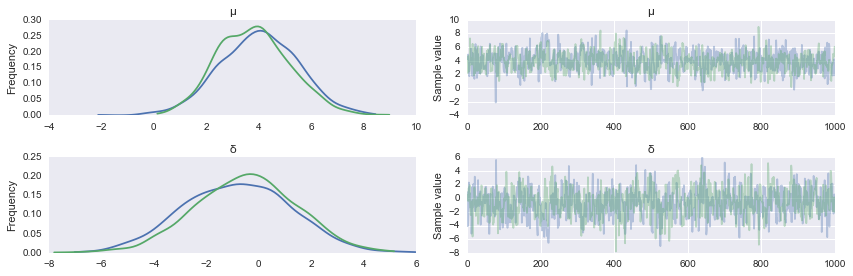

In [28]:
traceplot(school_trace[1000:], varnames=['μ', 'δ'])

Treatment effect on school days missed

In [29]:
summary(school_trace[1000:], varnames=['δ'])


δ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.655           1.999            0.080            [-4.425, 3.274]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -4.575         -2.007         -0.621         0.677          3.167



### Goodness of fit

In [33]:
school_ppc = sample_ppc(school_trace, model=school_days_model, samples=500)

In [37]:
bayes_p = lambda sim, true: [(s > t).mean() for s,t in zip(sim, true)]

sim_days = school_ppc['data_likelihood']
sim_days.shape

(500, 17)

Bayesian p-values for posterior predictive checks

In [44]:
(sim_days < y).mean(0)

array([ 0.81 ,  0.616,  0.548,  0.446,  0.606,  0.532,  0.656,  0.378,
        0.42 ,  0.548,  0.518,  0.58 ,  0.442,  0.334,  0.462,  0.404,
        0.52 ])